# Market Fear-Greed Indicator

### Install libraries

In [1]:
%pip install --upgrade --force-reinstall "protobuf==3.20.3" "googleapis-common-protos==1.59.1"

  Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl.metadata (698 bytes)
  Using cached googleapis_common_protos-1.59.1-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl (904 kB)
Using cached googleapis_common_protos-1.59.1-py2.py3-none-any.whl (224 kB)

  Attempting uninstall: protobuf

    Found existing installation: protobuf 3.20.3

    Uninstalling protobuf-3.20.3:

   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/

    scikit-learn (>=1.0.*) ; extra == 'pipelines'
                  ~~~~~~^
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.36.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


### Load libraries

In [2]:
import os
import re
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches     
from matplotlib.lines import Line2D

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, confusion_matrix, accuracy_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

In [3]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### File Paths & Data Loading

In [4]:
# File paths
REPO_DIR = Path.cwd()
DATA_FILE = REPO_DIR / "Data.csv"      # your file in the left pane
DATA_DIR = REPO_DIR / "data"           # where we’ll save CSV outputs
SAVE_DIR = REPO_DIR / "artifacts"      # plots, images, etc.
for d in (DATA_DIR, SAVE_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Keep raw Price cols in df (for v3 ratios), but do not use them as features in v1/v2
EXCLUDE_VIX_FEATURES = True  #  avoid any direct VIX* features to prevent leakage

In [5]:
REPO_DIR = Path.cwd()
DATA_FILE = REPO_DIR / "Data.csv"

def load_dataset():
    # 1) Prefer the copy in your repo
    if DATA_FILE.exists():
        df = pd.read_csv(DATA_FILE)
        print(f"Loaded: {DATA_FILE.resolve()} ({df.shape[0]} rows, {df.shape[1]} cols)")
        return df

    # 2) Fallback for environments that put uploads in /mnt/data
    alt = Path("/mnt/data/Data.csv")
    if alt.exists():
        df = pd.read_csv(alt)
        print(f"Loaded from {alt}. Creating a local copy in your repo at {DATA_FILE} ...")
        df.to_csv(DATA_FILE, index=False)
        return df

    raise FileNotFoundError(
        "Could not find Data.csv in the repo root or /mnt/data/. "
        "Please place Data.csv next to your notebook."
    )

def detect_date_column(df: pd.DataFrame) -> str:
    # Prefer exact 'Date'
    for c in df.columns:
        if c.lower() == "date":
            return c
    # Then anything containing 'date'
    candidates = [c for c in df.columns if "date" in c.lower()]
    if candidates:
        return candidates[0]
    # Finally, try to infer a mostly-parseable column
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() > 0.8:   # mostly datelike
                return c
        except Exception:
            pass
    raise ValueError("No date-like column found. Rename your date column to 'Date'.")

# run
df_raw = load_dataset()
date_col = detect_date_column(df_raw)
df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce")  # note: pd.to_datetime (not pd_to_datetime)
df_raw = df_raw.sort_values(by=date_col).reset_index(drop=True)

print("Date column detected:", date_col)
display(df_raw.head(3))

Loaded: C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\Data.csv (1098 rows, 23 cols)
Date column detected: Date


,Date,SPY_Price,SPY_Volatility,SPY_Volume,QQQ_Price,QQQ_Volatility,QQQ_Volume,GLD_Price,GLD_Volatility,GLD_Volume,...,VIX_Price,VIX_Fear_Level,TLT_Price,TLT_Volume,TLT_Volatility,CPIAUCSL,HOUST,BAMLH0A0HYM2,DGS10,UMCSENT
0,2021-04-01,400.61,0.135584,99682876,324.57,0.269009,55685602,161.98,0.145822,7105228,...,17.330000,Normal,137.51,14885947,0.149274,266.625,1495,3.33,1.69,88.3
1,2021-04-05,406.36,0.130192,91684764,331.05,0.272371,42172475,161.92,0.145895,6163799,...,17.910000,Normal,136.91,8242978,0.149656,266.625,1495,3.25,1.73,88.3
2,2021-04-06,406.12,0.127569,62020953,330.82,0.245731,33537210,163.22,0.141590,6761166,...,18.120001,Normal,137.84,9282395,0.149433,266.625,1495,3.25,1.67,88.3


### EDA

In [6]:
# EDA & Summary Stats

print("\nMissing values per column:")
missing_counts = df_raw.isna().sum().sort_values(ascending=False)
display(missing_counts.to_frame("missing_count"))

print("\nSummary statistics (numeric):")
display(df_raw.describe().T)


Missing values per column:


,missing_count
Date,0
HYG_Volume,0
DGS10,0
BAMLH0A0HYM2,0
HOUST,0
CPIAUCSL,0
TLT_Volatility,0
TLT_Volume,0
TLT_Price,0
VIX_Fear_Level,0



Summary statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
SPY_Price,1098.0,4.742124e+02,7.371594e+01,3.565600e+02,4.155375e+02,4.488750e+02,5.382100e+02,6.449500e+02
SPY_Volatility,1098.0,1.593263e-01,7.886554e-02,5.806804e-02,1.065117e-01,1.388771e-01,1.908038e-01,5.454354e-01
SPY_Volume,1098.0,7.543845e+07,2.965999e+07,2.604871e+07,5.597287e+07,7.076411e+07,8.920611e+07,2.566114e+08
QQQ_Price,1098.0,3.919625e+02,8.110425e+01,2.601000e+02,3.280450e+02,3.728800e+02,4.594100e+02,5.803400e+02
QQQ_Volatility,1098.0,2.123655e-01,9.422072e-02,6.985155e-02,1.465627e-01,1.870080e-01,2.634474e-01,6.105694e-01
QQQ_Volume,1098.0,4.950998e+07,2.058912e+07,1.533397e+07,3.525791e+07,4.626757e+07,5.891497e+07,1.994481e+08
GLD_Price,1098.0,2.000445e+02,4.360934e+01,1.512300e+02,1.691025e+02,1.808350e+02,2.210100e+02,3.162900e+02
GLD_Volatility,1098.0,1.439774e-01,4.172612e-02,6.807568e-02,1.174692e-01,1.368823e-01,1.622148e-01,3.158234e-01
GLD_Volume,1098.0,7.930876e+06,4.011137e+06,1.436508e+06,5.380274e+06,7.027098e+06,9.340751e+06,4.734768e+07
HYG_Price,1098.0,7.897282e+01,4.636298e+00,7.113000e+01,7.508000e+01,7.798000e+01,8.032750e+01,8.814000e+01


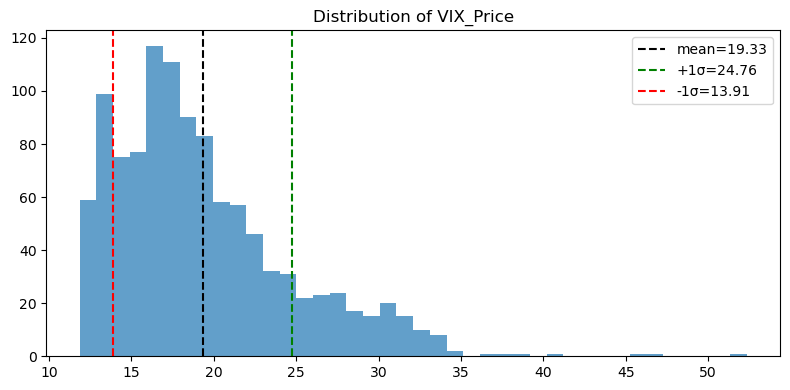

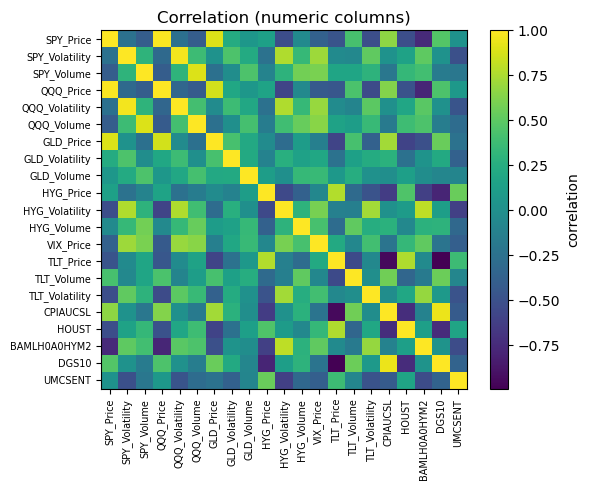

In [7]:
# EDA: Distribution of VIX_Price & Correlation Heatmap
if "VIX_Price" not in df_raw.columns:
    raise KeyError("VIX_Price not found in columns. Please ensure your dataset has a 'VIX_Price' column.")

vix = df_raw["VIX_Price"].astype(float)
mu, sigma = vix.mean(), vix.std()

plt.figure(figsize=(8,4))
plt.hist(vix.dropna().values, bins=40, alpha=0.7)
plt.axvline(mu, color="k", linestyle="--", label=f"mean={mu:.2f}")
plt.axvline(mu+sigma, color="g", linestyle="--", label=f"+1σ={mu+sigma:.2f}")
plt.axvline(mu-sigma, color="r", linestyle="--", label=f"-1σ={mu-sigma:.2f}")
plt.title("Distribution of VIX_Price")
plt.legend()
plt.tight_layout()
plt.show()

# Light-weight correlation heatmap for numeric cols
num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
corr = df_raw[num_cols].corr().clip(-1,1)
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto", interpolation="nearest")
plt.colorbar(label="correlation")
plt.title("Correlation (numeric columns)")
plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=7)
plt.yticks(range(len(num_cols)), num_cols, fontsize=7)
plt.tight_layout()
plt.show()

### Market Sentiment CLassification (based on VIX Price)

In [8]:
# Target Engineering: Market_Sentiment from VIX_Price
src_df = df_raw if 'df_raw' in globals() else df_80

mu    = src_df["VIX_Price"].astype(float).mean()
sigma = src_df["VIX_Price"].astype(float).std()

def vix_to_sentiment(v):
    if pd.isna(v): return np.nan
    if v > mu + sigma: return "fear"   # high VIX = fear
    if v < mu - sigma: return "greed"  # low  VIX = greed
    return "stable"

# apply to any dataset you’re using
if 'df_raw' in globals():
    df_raw["Market_Sentiment"] = df_raw["VIX_Price"].astype(float).apply(vix_to_sentiment)
if 'df_80' in globals():
    df_80["Market_Sentiment"] = df_80["VIX_Price"].astype(float).apply(vix_to_sentiment)

print(f"μ={mu:.3f}, σ={sigma:.3f}")
print("Counts (df_raw):" if 'df_raw' in globals() else "Counts (df_80):")
print((df_raw if 'df_raw' in globals() else df_80)["Market_Sentiment"].value_counts(dropna=False))

μ=19.332, σ=5.427
Counts (df_raw):
stable    770
fear      170
greed     158
Name: Market_Sentiment, dtype: int64


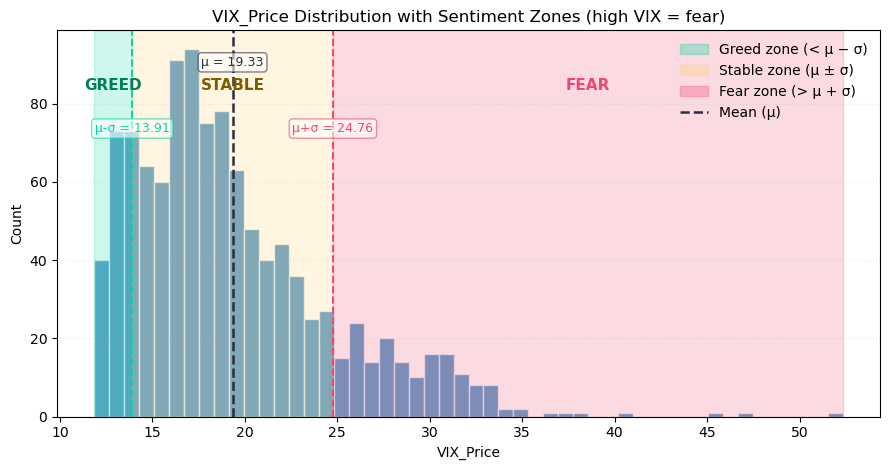

In [9]:
# Visual: VIX distribution with sentiment zones + counts
vix_all = df_raw["VIX_Price"].astype(float).dropna()

fear_thr  = mu + sigma     # high boundary
greed_thr = mu - sigma     # low boundary

# Colors (consistent with the rest of the notebook)
fear_color    = "#ef476f"   # red/pink
stable_color  = "#ffd166"   # amber/yellow
greed_color   = "#06d6a0"   # teal/green
line_color    = "#2b2d42"

# Histogram + shaded zones
fig, ax = plt.subplots(figsize=(9, 4.8))
n, bins, patches = ax.hist(vix_all, bins=50, alpha=0.70, edgecolor="white")
ax.set_xlabel("VIX_Price")
ax.set_ylabel("Count")
ax.set_title("VIX_Price Distribution with Sentiment Zones (high VIX = fear)")

# Shaded zones (LEFT = GREED, MIDDLE = STABLE, RIGHT = FEAR)
ax.axvspan(vix_all.min(), greed_thr,     color=greed_color,  alpha=0.20)
ax.axvspan(greed_thr,     fear_thr,      color=stable_color, alpha=0.20)
ax.axvspan(fear_thr,      vix_all.max(), color=fear_color,   alpha=0.20)

# Threshold lines
ax.axvline(mu,       color=line_color, ls="--", lw=1.8)
ax.axvline(greed_thr,color=greed_color,ls="--", lw=1.4)
ax.axvline(fear_thr, color=fear_color, ls="--", lw=1.4)

# Zone labels
y_top = max(n) * 0.90 if len(n) else ax.get_ylim()[1] * 0.90
ax.text((vix_all.min() + greed_thr) / 2, y_top, "GREED",  color="#007f5f",  ha="center", va="center", fontsize=11, weight="bold")
ax.text((greed_thr + fear_thr) / 2,     y_top, "STABLE", color="#7a5d00",  ha="center", va="center", fontsize=11, weight="bold")
ax.text((fear_thr + vix_all.max()) / 2, y_top, "FEAR",   color=fear_color, ha="center", va="center", fontsize=11, weight="bold")

# Annotations
ax.annotate(f"μ = {mu:.2f}",        xy=(mu, y_top),        xytext=(0, 12), textcoords="offset points",
            ha="center", va="bottom", fontsize=9, color=line_color,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=line_color, alpha=0.6))
ax.annotate(f"μ-σ = {greed_thr:.2f}", xy=(greed_thr, y_top*0.8), xytext=(0, 12), textcoords="offset points",
            ha="center", va="bottom", fontsize=9, color=greed_color,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=greed_color, alpha=0.6))
ax.annotate(f"μ+σ = {fear_thr:.2f}",  xy=(fear_thr, y_top*0.8),  xytext=(0, 12), textcoords="offset points",
            ha="center", va="bottom", fontsize=9, color=fear_color,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=fear_color, alpha=0.6))

# Legend
legend_handles = [
    mpatches.Patch(color=greed_color,  alpha=0.30, label="Greed zone (< μ − σ)"),
    mpatches.Patch(color=stable_color, alpha=0.30, label="Stable zone (μ ± σ)"),
    mpatches.Patch(color=fear_color,   alpha=0.30, label="Fear zone (> μ + σ)"),
    Line2D([0], [0], color=line_color, ls="--", lw=1.8, label="Mean (μ)")
]
ax.legend(handles=legend_handles, loc="upper right", frameon=False)

ax.grid(axis="y", alpha=0.25, linestyle=":")
plt.tight_layout()
plt.savefig(SAVE_DIR / "vix_distribution_sentiment_zones.png", bbox_inches="tight")
plt.show()

In [10]:
# Chronological Split: Last 20% held out for future use (saved in repo)

base_df = df_raw.copy() if 'df_raw' in globals() else df_80.copy()

# keep chronological order if a date column is defined
if 'date_col' in globals() and date_col in base_df.columns:
    base_df = base_df.sort_values(by=date_col)

# 80/20 split
cut_idx = int(np.floor(len(base_df) * 0.8))
df_80        = base_df.iloc[:cut_idx].copy()
df_20_future = base_df.iloc[cut_idx:].copy()

# save locally
DATA_DIR = Path("./data"); DATA_DIR.mkdir(parents=True, exist_ok=True)
df_80.to_csv(DATA_DIR / "model_base_80pct.csv", index=False)
df_20_future.to_csv(DATA_DIR / "future_holdout_20pct.csv", index=False)

print("Saved:", (DATA_DIR / "model_base_80pct.csv").resolve())
print("Saved:", (DATA_DIR / "future_holdout_20pct.csv").resolve())
display(df_20_future.head(2))

Saved: C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\data\model_base_80pct.csv
Saved: C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\data\future_holdout_20pct.csv


,Date,SPY_Price,SPY_Volatility,SPY_Volume,QQQ_Price,QQQ_Volatility,QQQ_Volume,GLD_Price,GLD_Volatility,GLD_Volume,...,VIX_Fear_Level,TLT_Price,TLT_Volume,TLT_Volatility,CPIAUCSL,HOUST,BAMLH0A0HYM2,DGS10,UMCSENT,Market_Sentiment
878,2024-09-27,571.47,0.140546,42100928,486.75,0.211098,22851120,245.02,0.130943,8329633,...,Normal,98.57,28317628,0.113218,314.131,1391,3.14,3.75,67.9,stable
879,2024-09-30,573.76,0.137526,63655448,488.07,0.207727,30330605,243.06,0.131834,6919352,...,Normal,98.10,34208260,0.107247,314.131,1391,3.03,3.81,67.9,stable


## Feature Engineering (v1, v2, v3)

##### The following features have been created: 



#### **v1:** **Percentage price change** is used instead of price to normalize the price values. 
#### **v2:** **7 day** and **30 day** moving average price featues created to smoothen out daily price fluctuations and provide better signal
#### **v3:** **Ratios** created using the price, volume and volatility metrics to better generate signal from the data. 

In [11]:
# Feature Engineering Utils (v1, v2, v3)

def safe_ratio(a: pd.Series, b: pd.Series, eps=1e-9):
    return a / (b.replace(0, np.nan) + eps)

def is_vix_price_col(col) -> bool:
    c = str(col).strip().lower()
    return c == "vix_price" or c.endswith("vix_price")

def find_columns_by_suffix(df: pd.DataFrame, suffix="Price", exclude_vix_price=True):
    """Case-insensitive endswith match (e.g., *_Price, *_Volume). Optionally drop VIX_Price."""
    sfx = str(suffix).lower()
    cols = [str(c) for c in df.columns if str(c).lower().endswith(sfx)]
    if exclude_vix_price:
        cols = [c for c in cols if not is_vix_price_col(c)]
    return cols

def _filter_out_any_vix_price_features(names):
    """Remove ANY feature whose name mentions vix_price (ret, ma, ratios, etc.)."""
    return [n for n in names if "vix_price" not in str(n).lower() and str(n) != "VIX_Price"]

#### v1

In [12]:
def build_v1_features(df_in: pd.DataFrame, date_col: str, exclude_vix=True):
    """
    v1: Returns for *_Price columns EXCEPT VIX_Price.
        Keep raw prices in df (for later ratios), but NEVER use raw prices as features.
        Also exclude any pre-existing feature that mentions 'vix_price'.
    """
    df = df_in.copy()

    # returns for all price columns EXCEPT VIX_Price
    price_cols = find_columns_by_suffix(df, "Price", exclude_vix_price=True)
    for c in price_cols:
        df[f"{c}_ret_pct"] = df[c].astype(float).pct_change() * 100.0

    forbidden = {date_col, "Market_Sentiment", "VIX_Fear_level", "VIX_Price"}
    ret_feats = [c for c in df.columns if c.endswith("_ret_pct")]
    ret_feats = _filter_out_any_vix_price_features(ret_feats)

    base_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    extra_numeric = [
        c for c in base_numeric
        if c not in forbidden
        and not str(c).lower().endswith("price")
        and not str(c).endswith("_ret_pct")
        and "vix_price" not in str(c).lower()
    ]

    feature_cols = sorted(set(ret_feats + extra_numeric))
    feature_cols = _filter_out_any_vix_price_features(feature_cols)
    return df, feature_cols

#### v2

In [13]:
def build_v2_features(df_in: pd.DataFrame, date_col: str, exclude_vix=True):
    """
    v2: v1 + 7/30-day moving averages for non-VIX prices.
    """
    df = df_in.copy()

    price_cols = find_columns_by_suffix(df, "Price", exclude_vix_price=True)  # excludes VIX_Price
    for c in price_cols:
        df[f"{c}_ma7"]  = df[c].astype(float).rolling(window=7,  min_periods=1).mean()
        df[f"{c}_ma30"] = df[c].astype(float).rolling(window=30, min_periods=1).mean()

    df_v1, v1_feats = build_v1_features(df, date_col=date_col, exclude_vix=exclude_vix)

    ma_feats = [f"{c}_ma7" for c in price_cols] + [f"{c}_ma30" for c in price_cols]
    ma_feats = _filter_out_any_vix_price_features(ma_feats)

    v2_feats = sorted(set(v1_feats + ma_feats))
    v2_feats = _filter_out_any_vix_price_features(v2_feats)
    return df_v1, v2_feats

#### v3

In [14]:
def build_v3_features(df_in: pd.DataFrame, date_col: str, exclude_vix=True):
    """
    v3: v2 + ratios (price/price, volume/volume, price/volatility) — NEVER involving VIX_Price.
    """
    df = df_in.copy()

    df_v2, v2_feats = build_v2_features(df, date_col=date_col, exclude_vix=exclude_vix)

    price_cols  = find_columns_by_suffix(df_v2, "Price",  exclude_vix_price=True)  # excludes VIX_Price
    volume_cols = find_columns_by_suffix(df_v2, "Volume", exclude_vix_price=False)
    vol_cols    = [c for c in df_v2.columns if str(c).lower().endswith("volatility")]

    KEY_TICKERS = ["SPY", "GLD", "QQQ", "IWM", "DIA", "TLT"]  # intentionally omit VIX

    def pick_key_cols(cols):
        picks = [c for c in cols if any(k.lower() in str(c).lower() for k in KEY_TICKERS)]
        return picks if picks else [c for c in cols if "vix" not in str(c).lower()][:3]

    price_key  = pick_key_cols(price_cols)
    volume_key = pick_key_cols(volume_cols)
    vol_key    = pick_key_cols(vol_cols) if vol_cols else []

    ratio_feats = []

    for i in range(len(price_key)):
        for j in range(i + 1, len(price_key)):
            a, b = price_key[i], price_key[j]
            new_col = f"ratio_{a}_over_{b}"
            df_v2[new_col] = safe_ratio(df_v2[a].astype(float), df_v2[b].astype(float))
            ratio_feats.append(new_col)

    for i in range(len(volume_key)):
        for j in range(i + 1, len(volume_key)):
            a, b = volume_key[i], volume_key[j]
            new_col = f"ratio_{a}_over_{b}"
            df_v2[new_col] = safe_ratio(df_v2[a].astype(float), df_v2[b].astype(float))
            ratio_feats.append(new_col)

    for p in price_key:
        for v in vol_key:
            new_col = f"ratio_{p}_over_{v}"
            df_v2[new_col] = safe_ratio(df_v2[p].astype(float), df_v2[v].astype(float))
            ratio_feats.append(new_col)

    v3_feats = sorted(set(v2_feats + ratio_feats))
    v3_feats = _filter_out_any_vix_price_features(v3_feats)
    return df_v2, v3_feats

## Prediction Model (Target = VIX Price; Proxy for market fear/greed)

In [15]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def chronological_train_val_split(df_in: pd.DataFrame, y_col: str, feature_cols: list, date_col: str, val_frac=0.3):
    df_sorted = df_in.sort_values(by=date_col).dropna(subset=[y_col])
    X = df_sorted[feature_cols].copy()
    y = df_sorted[y_col].astype(float).copy()
    mask = ~X.isna().any(axis=1)
    X, y, df_sorted = X[mask], y[mask], df_sorted[mask]
    n = len(X)
    split_idx = int(np.floor(n * (1 - val_frac)))
    X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]
    idx_train, idx_val = X_train.index, X_val.index
    return X_train, X_val, y_train, y_val, idx_train, idx_val

In [16]:
def build_preprocessor(X: pd.DataFrame):
    numeric_features = X.columns.tolist()
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    return ColumnTransformer(
        transformers=[("num", numeric_transformer, numeric_features)],
        remainder="drop"
    )

In [17]:
def candidate_models_reg():
    """Exactly three models: regression-based, tree-based, gradient-boosting-based."""
    return {
        "ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
        "rf": RandomForestRegressor(
            n_estimators=400, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1
        ),
        "hgb": HistGradientBoostingRegressor(
            learning_rate=0.05, max_depth=None, max_iter=500, random_state=RANDOM_STATE
        ),
    }

def value_to_sentiment(v, mu, sigma):
    if pd.isna(v): 
        return np.nan
    if v > mu + sigma:
        return "fear"     
    if v < mu - sigma:
        return "greed"    
    return "stable"

#### Market Sentiment Visualization

In [18]:
# Intuitive visuals 

fear_color   = "#ef476f"  # red/pink
stable_color = "#ffd166"  # amber/yellow
greed_color  = "#06d6a0"  # teal/green
line_color   = "#2b2d42"  # dark gray
series_color = "#1f77b4"  # default blue

In [19]:
# Best model results plot
def _binned_stats(x, y, q=10):
    """Quantile-binned means & std for calibration-like plot."""
    qs = np.linspace(0, 1, q+1)
    edges = np.quantile(x, qs)
    edges[0] -= 1e-9; edges[-1] += 1e-9
    bins = np.digitize(x, edges[1:-1])
    x_means, y_means, y_stds = [], [], []
    for b in range(q):
        msk = bins == b
        if msk.sum() == 0:
            x_means.append(np.nan); y_means.append(np.nan); y_stds.append(np.nan)
        else:
            x_means.append(np.mean(x[msk]))
            y_means.append(np.mean(y[msk]))
            y_stds.append(np.std(y[msk]))
    return np.array(x_means), np.array(y_means), np.array(y_stds)

In [20]:
def plot_best_model_graphs(y_true: pd.Series, y_pred: pd.Series, prefix: str, vix_mu: float, vix_sigma: float):
    """Exactly 3 graphs: (1) density hexbin; (2) calibration (binned); (3) errors by actual zone."""
    # 1) Density hexbin: Actual vs Predicted with identity & zone lines
    fig, ax = plt.subplots(figsize=(6.2, 5.6))
    hb = ax.hexbin(y_true, y_pred, gridsize=35, mincnt=1, cmap="viridis")
    plt.colorbar(hb, ax=ax, label="count")
    mn, mx = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
    ax.plot([mn, mx], [mn, mx], ls="--", lw=1.8, color=line_color, label="identity")
    ax.axvline(vix_mu - vix_sigma, color=greed_color,  ls="--", lw=1.2)   # low VIX boundary (greed)
    ax.axvline(vix_mu,             color=line_color,   ls="--", lw=1.2)
    ax.axvline(vix_mu + vix_sigma, color=fear_color,   ls="--", lw=1.2)   # high VIX boundary (fear)
    ax.axhline(vix_mu - vix_sigma, color=greed_color,  ls=":",  lw=1.0)
    ax.axhline(vix_mu + vix_sigma, color=fear_color,   ls=":",  lw=1.0)
    ax.set_xlabel("Actual VIX")
    ax.set_ylabel("Predicted VIX")
    ax.set_title(f"Actual vs Predicted (density) – {prefix}")
    ax.legend(loc="upper left", frameon=False)
    plt.tight_layout()
    plt.savefig(SAVE_DIR / f"best_hex_actual_vs_pred_{prefix}.png", bbox_inches="tight")
    plt.show()

    # 2) Calibration-style: binned means (±1σ)
    x_mean, y_mean, y_std = _binned_stats(y_true.values, y_pred.values, q=10)
    fig, ax = plt.subplots(figsize=(6.2, 4.8))
    ax.plot([np.nanmin(x_mean), np.nanmax(x_mean)], [np.nanmin(x_mean), np.nanmax(x_mean)],
            ls="--", color=line_color, lw=1.6, label="ideal")
    ax.errorbar(x_mean, y_mean, yerr=y_std, fmt="o-", lw=1.7, ms=4, capsize=3,
                color=series_color, label="binned mean ±1σ")
    ax.set_xlabel("Actual VIX (binned mean)")
    ax.set_ylabel("Predicted VIX (mean)")
    ax.set_title(f"Calibration (binned) – {prefix}")
    ax.grid(alpha=0.25, linestyle=":")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(SAVE_DIR / f"best_calibration_{prefix}.png", bbox_inches="tight")
    plt.show()

    # 3) Errors by Actual Zone (MAE & RMSE bars) with swapped mapping
    def zone_of(v):
        if v > vix_mu + vix_sigma: return "fear"     # swapped
        if v < vix_mu - vix_sigma: return "greed"    # swapped
        return "stable"
    zones = pd.Series([zone_of(v) for v in y_true], index=y_true.index)
    rows = []
    for label in ["greed","stable","fear"]:  # order left->right
        m = zones == label
        if m.sum() == 0:
            rows.append((label, np.nan, np.nan))
        else:
            rows.append((label,
                         mean_absolute_error(y_true[m], y_pred[m]),
                         rmse(y_true[m], y_pred[m])))
    labels, maes, rmses = zip(*rows)
    colors = [greed_color, stable_color, fear_color]
    x = np.arange(len(labels)); w = 0.38
    fig, ax = plt.subplots(figsize=(6.8, 4.4))
    ax.bar(x - w/2, maes,  width=w, color=colors, edgecolor="white", label="MAE")
    ax.bar(x + w/2, rmses, width=w, color=[c+"cc" for c in colors], edgecolor="white", label="RMSE")
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_ylabel("Error")
    ax.set_title(f"Errors by Actual Zone – {prefix}")
    ax.grid(axis="y", alpha=0.25, linestyle=":")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(SAVE_DIR / f"best_errors_by_zone_{prefix}.png", bbox_inches="tight")
    plt.show()

In [21]:
def style_results_table(df: pd.DataFrame, sort_cols=("RMSE","MAE","R2")):
    df_fmt = df.copy()
    for col in ["RMSE","MAE","R2","Sent_Acc","Sent_MacroF1","Sent_WeightedF1"]:
        if col in df_fmt.columns:
            if col == "R2":
                df_fmt[col] = df_fmt[col].map(lambda x: np.nan if pd.isna(x) else round(x, 3))
            else:
                df_fmt[col] = df_fmt[col].map(lambda x: np.nan if pd.isna(x) else round(x, 3))
    sty = (df_fmt
           .sort_values(list(sort_cols), ascending=[True, True, False])
           .style
           .hide(axis='index')
           .set_caption("Model comparison (lower RMSE/MAE is better; higher R²/Acc/F1 is better)")
           .highlight_min(subset=["RMSE","MAE"], color="#d1fae5")   # light green
           .highlight_max(subset=["R2","Sent_Acc","Sent_MacroF1","Sent_WeightedF1"], color="#ffe4b5")  # light amber
          )
    display(sty)

#### Model Training & Eval

In [22]:
def model_fit_eval_regression(
    df80: pd.DataFrame, feature_cols: list, feature_set_name: str, date_col: str,
    vix_mu: float, vix_sigma: float, target_col="VIX_Price"
):
    # NOTE: feature_cols are used as passed in (your v1/v2/v3 builders already exclude any VIX-derived features)
    X_train, X_val, y_train, y_val, idx_train, idx_val = chronological_train_val_split(
        df80, target_col, feature_cols, date_col, val_frac=0.3
    )
    preprocessor = build_preprocessor(X_train)

    models = candidate_models_reg()
    true_sent = df80.loc[idx_val, "Market_Sentiment"].astype(str)

    results = []
    best_name, best_rmse, best_pipe, best_pred = None, np.inf, None, None

    # ---- Train the three models
    for name, model in models.items():
        pipe = Pipeline(steps=[("prep", preprocessor), ("reg", model)])
        pipe.fit(X_train, y_train)

        y_pred = pd.Series(pipe.predict(X_val), index=idx_val, name="VIX_Pred")

        mae  = mean_absolute_error(y_val, y_pred.loc[y_val.index])
        errm = rmse(y_val, y_pred.loc[y_val.index])
        r2   = r2_score(y_val, y_pred.loc[y_val.index])

        # Derived sentiment comparison (predicted VIX -> label vs existing labels)
        pred_sent = y_pred.apply(lambda v: value_to_sentiment(v, vix_mu, vix_sigma))
        sent_acc = accuracy_score(true_sent, pred_sent)
        try:
            rep = classification_report(true_sent, pred_sent, output_dict=True, zero_division=0)
            macro_f1 = rep["macro avg"]["f1-score"]; weighted_f1 = rep["weighted avg"]["f1-score"]
        except Exception:
            macro_f1, weighted_f1 = np.nan, np.nan

        results.append({
            "feature_set": feature_set_name,
            "model": name,
            "RMSE": errm, "MAE": mae, "R2": r2,
            "Sent_Acc": sent_acc, "Sent_MacroF1": macro_f1, "Sent_WeightedF1": weighted_f1
        })

        if errm < best_rmse:
            best_rmse = errm
            best_name = name
            best_pipe = pipe
            best_pred = y_pred.copy()

    # ---- Nicely formatted results table
    results_df = pd.DataFrame(results)
    print(f"\n=== Results for {feature_set_name} (best highlighted) ===")
    style_results_table(results_df)

    # ---- Best model: 3 concise plots + save validation CSV
    prefix = f"{feature_set_name}_{best_name}"
    val_out = pd.DataFrame({
        date_col: df80.loc[idx_val, date_col],
        "VIX_Actual": y_val.loc[idx_val],
        "VIX_Pred":   best_pred,
        "True_Sentiment": true_sent,
        "Predicted_Sentiment": best_pred.apply(lambda v: value_to_sentiment(v, vix_mu, vix_sigma))
    }).dropna(subset=["VIX_Actual", "VIX_Pred", "True_Sentiment"])
    out_csv = DATA_DIR / f"val_predictions_{prefix}.csv"
    val_out.to_csv(out_csv, index=False)

    # Only these 3 plots for the best model:
    plot_best_model_graphs(y_val.loc[idx_val], best_pred, prefix, vix_mu, vix_sigma)

    return best_pipe, results_df

### Model - V1

v1 features: 20 columns

=== Results for v1 (best highlighted) ===


feature_set,model,RMSE,MAE,R2,Sent_Acc,Sent_MacroF1,Sent_WeightedF1
v1,hgb,2.570000,2.026000,0.299000,0.527000,0.461000,0.457000
v1,rf,2.664000,2.134000,0.247000,0.527000,0.396000,0.368000
v1,ridge,6.369000,5.190000,-3.305000,0.583000,0.375000,0.549000


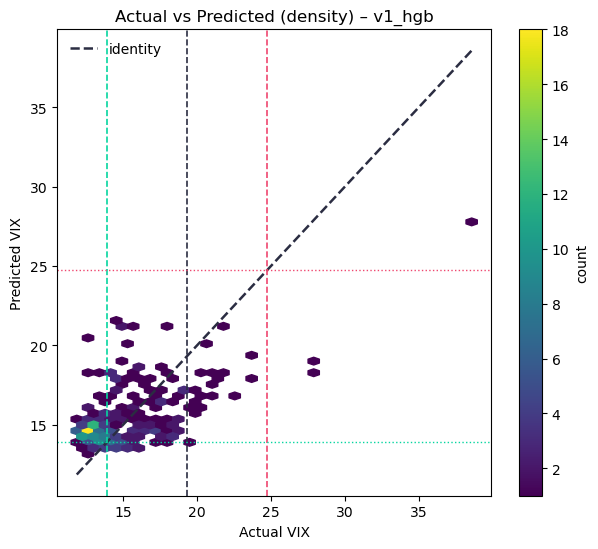

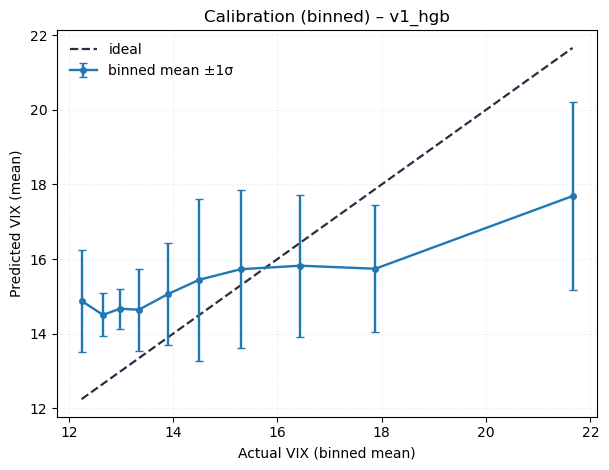

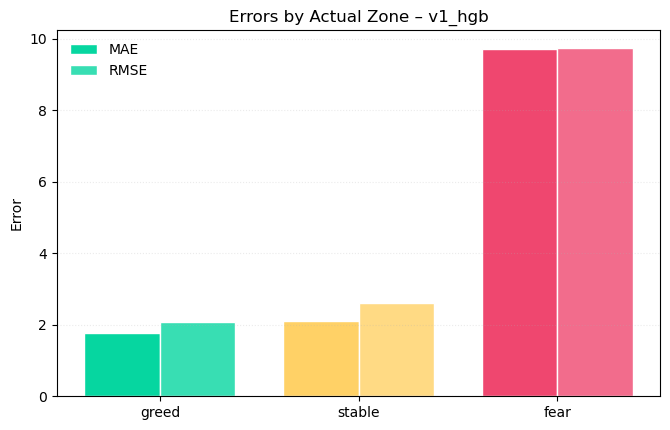

In [23]:
# V1: Percent daily returns
df80_v1, v1_features = build_v1_features(df_80, date_col=date_col, exclude_vix=EXCLUDE_VIX_FEATURES)
print(f"v1 features: {len(v1_features)} columns")

df80_v1 = df80_v1.dropna(subset=["VIX_Price"])
df80_v1["VIX_Price"] = df80_v1["VIX_Price"].astype(float)

best_v1_pipe, v1_results = model_fit_eval_regression(
    df80_v1, v1_features, "v1", date_col=date_col, vix_mu=mu, vix_sigma=sigma, target_col="VIX_Price"
)

### Model - V2

v2 features: 30 columns

=== Results for v2 (best highlighted) ===


feature_set,model,RMSE,MAE,R2,Sent_Acc,Sent_MacroF1,Sent_WeightedF1
v2,hgb,2.651000,2.184000,0.254000,0.542000,0.424000,0.407000
v2,rf,3.159000,2.700000,-0.059000,0.527000,0.396000,0.368000
v2,ridge,9.233000,7.330000,-8.048000,0.614000,0.386000,0.564000


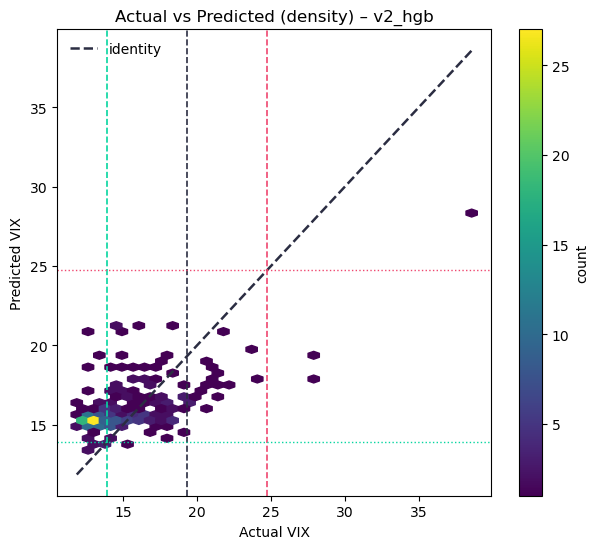

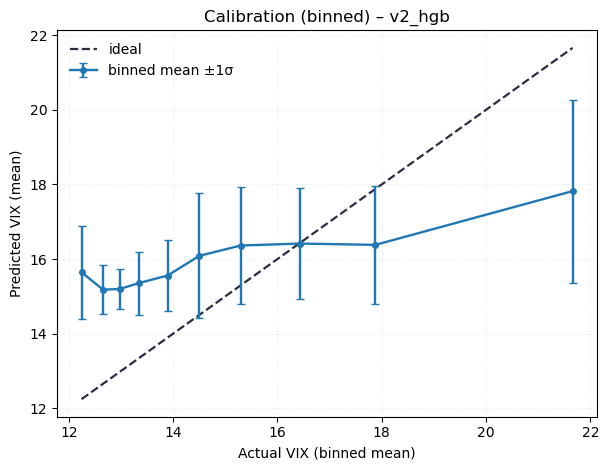

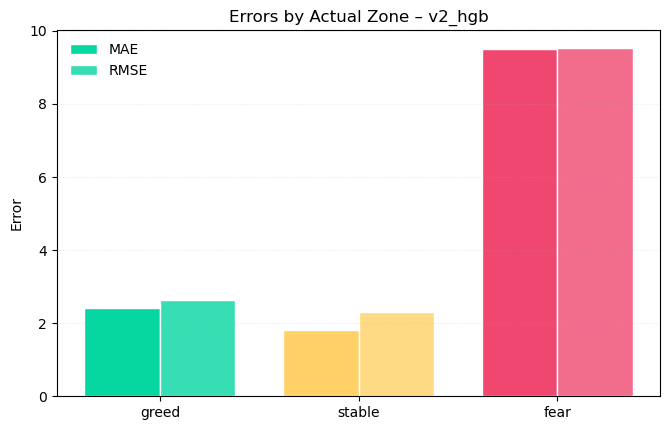

In [24]:
# V2: v1 + 7/30 day moving averages
df80_v2, v2_features = build_v2_features(df_80, date_col=date_col, exclude_vix=EXCLUDE_VIX_FEATURES)
print(f"v2 features: {len(v2_features)} columns")

df80_v2 = df80_v2.dropna(subset=["VIX_Price"])
df80_v2["VIX_Price"] = df80_v2["VIX_Price"].astype(float)

best_v2_pipe, v2_results = model_fit_eval_regression(
    df80_v2, v2_features, "v2", date_col=date_col, vix_mu=mu, vix_sigma=sigma, target_col="VIX_Price"
)

### Model - V3

v3 features: 58 columns

=== Results for v3 (best highlighted) ===


feature_set,model,RMSE,MAE,R2,Sent_Acc,Sent_MacroF1,Sent_WeightedF1
v3,hgb,2.769000,2.154000,0.186000,0.538000,0.414000,0.393000
v3,rf,3.139000,2.685000,-0.046000,0.530000,0.397000,0.370000
v3,ridge,10.522000,8.495000,-10.749000,0.614000,0.387000,0.566000


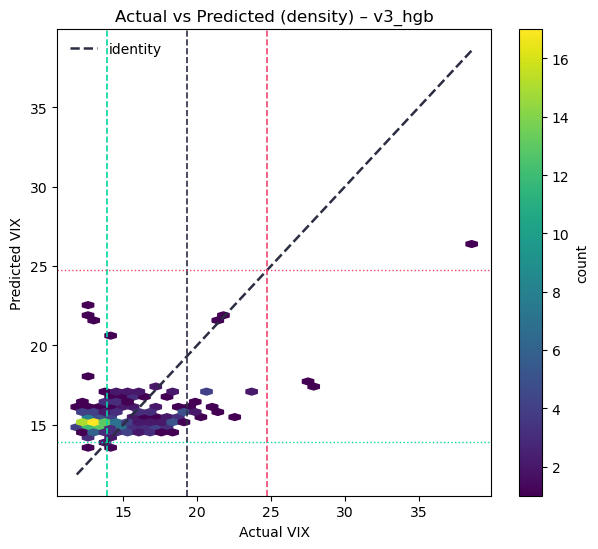

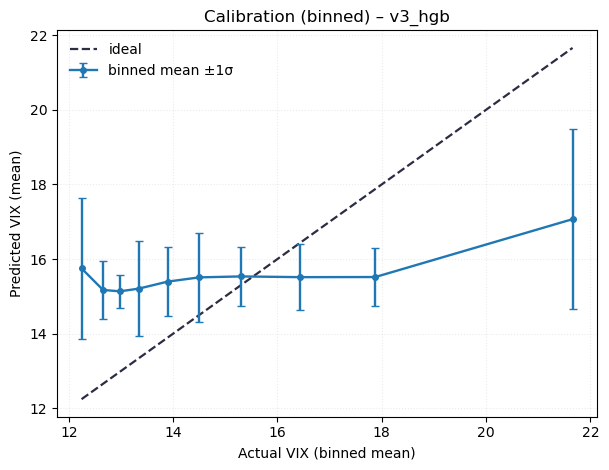

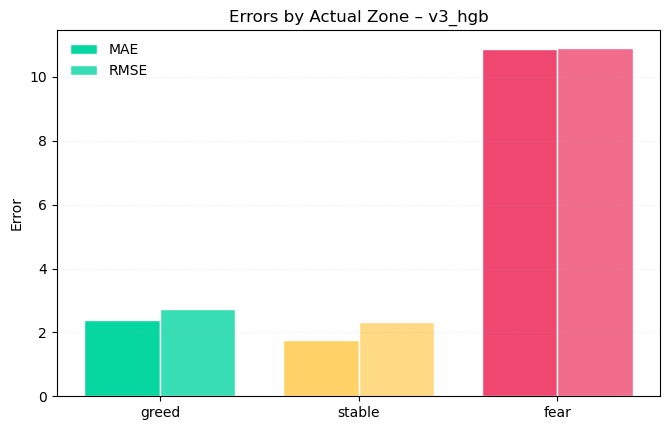

In [25]:
# v3: v2 + selected ratio features 
df80_v3, v3_features = build_v3_features(df_80, date_col=date_col, exclude_vix=EXCLUDE_VIX_FEATURES)
print(f"v3 features: {len(v3_features)} columns")

df80_v3 = df80_v3.dropna(subset=["VIX_Price"])
df80_v3["VIX_Price"] = df80_v3["VIX_Price"].astype(float)

best_v3_pipe, v3_results = model_fit_eval_regression(
    df80_v3, v3_features, "v3", date_col=date_col, vix_mu=mu, vix_sigma=sigma, target_col="VIX_Price"
)

### Feature Importance

In [26]:
BASE_COLOR      = "#4e79a7"  # steel blue
HIGHLIGHT_COLOR = "#f28e2b"  # orange for top-5
AXIS_COLOR      = "#2b2d42"

def _model_name(pipe):
    return type(pipe.named_steps["reg"]).__name__

def _compute_importance(pipe, X_val, y_val, feature_cols, random_state=RANDOM_STATE, top_n=20):
    model = pipe.named_steps["reg"]
    if hasattr(model, "feature_importances_"):
        vals = np.asarray(model.feature_importances_, dtype=float); method = "native"
    elif hasattr(model, "coef_"):
        vals = np.abs(np.ravel(model.coef_).astype(float)); method = "coeff |abs|"
    else:
        r = permutation_importance(pipe, X_val, y_val, n_repeats=5, random_state=random_state, n_jobs=-1)
        vals = r.importances_mean; method = "permutation"

    names = np.array(feature_cols, dtype=str)
    m = min(len(vals), len(names)); vals, names = vals[:m], names[:m]
    order = np.argsort(vals)[::-1][:top_n]
    return names[order], vals[order], method

In [27]:
def _plot_importance(names_top, vals_top, version_label, model_name, method, save_basename):
    y = np.arange(len(names_top))
    fig, ax = plt.subplots(figsize=(8.8, max(5, 0.35*len(names_top)+1)))
    bars = ax.barh(y, vals_top, color=BASE_COLOR, edgecolor="white")
    for i in range(min(5, len(bars))): bars[i].set_color(HIGHLIGHT_COLOR)
    ax.set_yticks(y); ax.set_yticklabels(names_top); ax.invert_yaxis()
    ax.set_xlabel("Importance", color=AXIS_COLOR)
    ax.set_title(f"Feature Importance — {version_label.upper()}  •  {model_name}  ({method})", color=AXIS_COLOR)
    ax.grid(axis="x", alpha=0.25, linestyle=":")
    for i, v in enumerate(vals_top):
        ax.text(v + (vals_top.max()*0.01 if vals_top.max() > 0 else 0.01), i, f"{v:.3f}", va="center", ha="left", fontsize=9)
    plt.tight_layout()
    out_path = SAVE_DIR / f"{save_basename}.png"; plt.savefig(out_path, bbox_inches="tight"); plt.show()
    print(f"Saved: {out_path.resolve()}")

In [28]:
def _val_split(df_version, feature_cols):
    # use the exact feature list passed in
    X_tr, X_va, y_tr, y_va, *_ = chronological_train_val_split(
        df_version, "VIX_Price", feature_cols, date_col, val_frac=0.3
    )
    return X_va, y_va

def _ensure_best_pipe(version_label):
    """Return (best_pipe, df_version, feature_cols). Train if needed."""
    if version_label == "v1":
        df_version, feature_cols = df80_v1, v1_features
        pipe = globals().get("best_v1_pipe")
        if pipe is None:
            df_version = df_version.dropna(subset=["VIX_Price"]).copy()
            df_version["VIX_Price"] = df_version["VIX_Price"].astype(float)
            pipe, _ = model_fit_eval_regression(
                df_version, feature_cols, "v1", date_col=date_col, vix_mu=mu, vix_sigma=sigma, target_col="VIX_Price"
            )
            globals()["best_v1_pipe"] = pipe
    elif version_label == "v2":
        df_version, feature_cols = df80_v2, v2_features
        pipe = globals().get("best_v2_pipe")
        if pipe is None:
            df_version = df_version.dropna(subset=["VIX_Price"]).copy()
            df_version["VIX_Price"] = df_version["VIX_Price"].astype(float)
            pipe, _ = model_fit_eval_regression(
                df_version, feature_cols, "v2", date_col=date_col, vix_mu=mu, vix_sigma=sigma, target_col="VIX_Price"
            )
            globals()["best_v2_pipe"] = pipe
    else:
        df_version, feature_cols = df80_v3, v3_features
        pipe = globals().get("best_v3_pipe")
        if pipe is None:
            df_version = df_version.dropna(subset=["VIX_Price"]).copy()
            df_version["VIX_Price"] = df_version["VIX_Price"].astype(float)
            pipe, _ = model_fit_eval_regression(
                df_version, feature_cols, "v3", date_col=date_col, vix_mu=mu, vix_sigma=sigma, target_col="VIX_Price"
            )
            globals()["best_v3_pipe"] = pipe
    return pipe, df_version, feature_cols

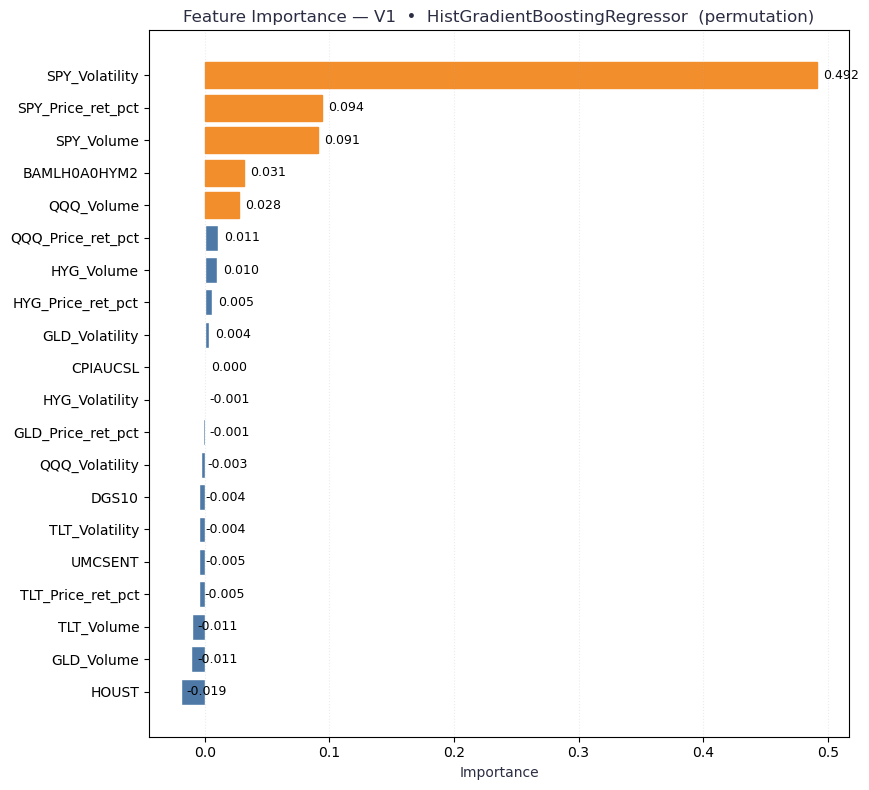

Saved: C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\artifacts\feat_importance_best_v1_histgradientboostingregressor.png


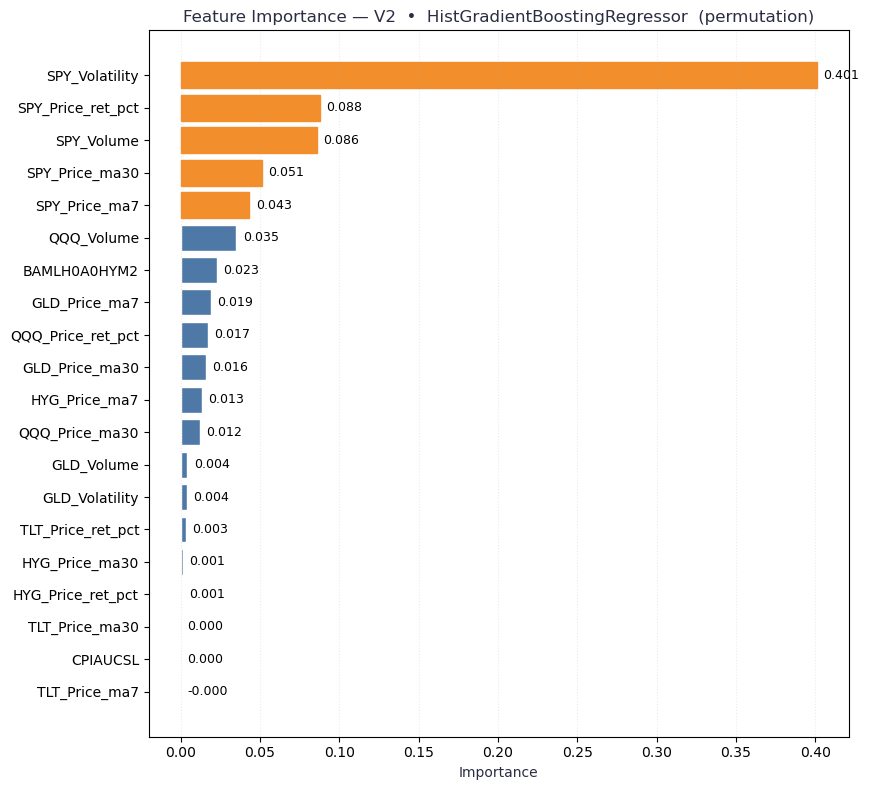

Saved: C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\artifacts\feat_importance_best_v2_histgradientboostingregressor.png


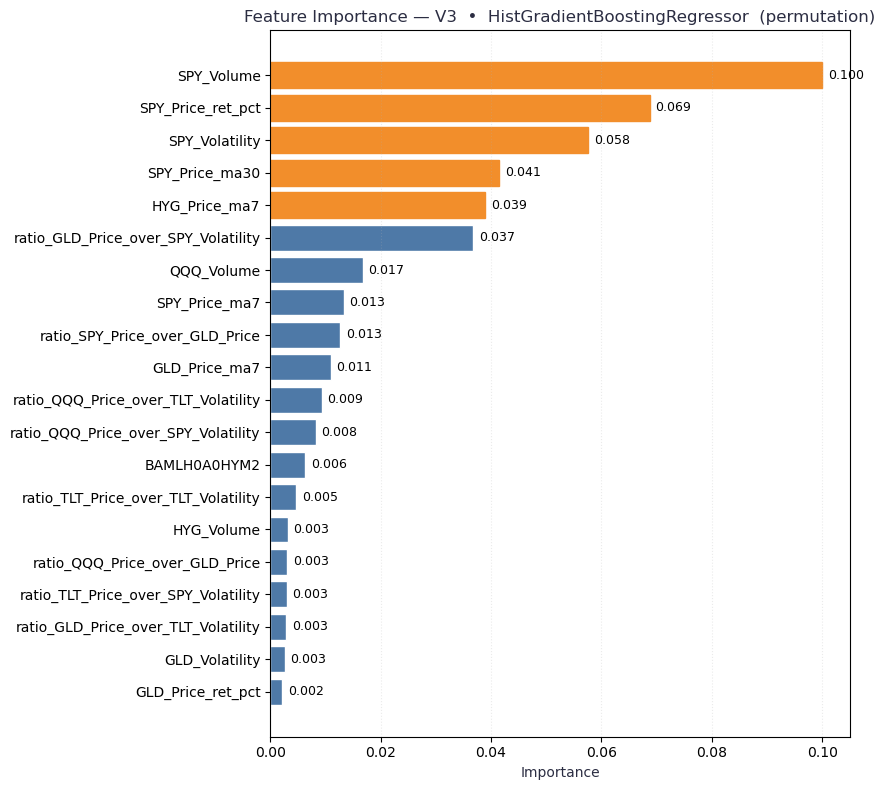

Saved: C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\artifacts\feat_importance_best_v3_histgradientboostingregressor.png


In [29]:
def _importance_for_version(version_label):
    pipe, df_version, feature_cols = _ensure_best_pipe(version_label)
    X_val, y_val = _val_split(df_version, feature_cols)
    names_top, vals_top, method = _compute_importance(pipe, X_val, y_val, feature_cols, top_n=20)
    model_name = _model_name(pipe)
    _plot_importance(
        names_top, vals_top, version_label, model_name, method,
        save_basename=f"feat_importance_best_{version_label}_{model_name.lower()}"
    )

# Generate plots (will train best models if they don't exist yet)
_importance_for_version("v1")
_importance_for_version("v2")
_importance_for_version("v3")

### Pick Best Model Across v1–v3 & Summarize

In [30]:
# Compare feature sets and pick the best by RMSE 
def _pick_best(df: pd.DataFrame, version_label: str) -> pd.DataFrame:
    """Return a 1-row DataFrame for the best model by RMSE, then MAE, then R²."""
    if df is None or len(df) == 0:
        return pd.DataFrame()
    sort_cols = ["RMSE", "MAE", "R2"]
    asc = [True, True, False]  # lower RMSE/MAE better; higher R² better
    best_df = df.sort_values(by=sort_cols, ascending=asc).head(1).copy()
    best_df["feature_version"] = version_label
    return best_df

summary = pd.concat(
    [
        _pick_best(v1_results, "v1"),
        _pick_best(v2_results, "v2"),
        _pick_best(v3_results, "v3"),
    ],
    ignore_index=True,
)

def style_summary_table(df: pd.DataFrame):
    df_fmt = df.copy()

    # Round numeric columns we might have
    round_cols = [c for c in ["RMSE","MAE","R2","Sent_Acc","Sent_MacroF1","Sent_WeightedF1"] if c in df_fmt.columns]
    for col in round_cols:
        df_fmt[col] = df_fmt[col].apply(lambda x: np.nan if pd.isna(x) else round(float(x), 3))

    # Sorting (only by the columns that exist)
    sort_cols = [c for c in ["RMSE","MAE","R2"] if c in df_fmt.columns]
    sort_asc  = [True, True, False][:len(sort_cols)]
    df_fmt = df_fmt.sort_values(by=sort_cols, ascending=sort_asc)

    sty = (
        df_fmt.style
        .hide(axis="index")
        .set_caption("Best model per feature version (lower RMSE/MAE is better; higher R²/Acc/F1 is better)")
    )

    # Highlights (only for columns that exist)
    min_cols = [c for c in ["RMSE","MAE"] if c in df_fmt.columns]
    max_cols = [c for c in ["R2","Sent_Acc","Sent_MacroF1","Sent_WeightedF1"] if c in df_fmt.columns]
    if min_cols:
        sty = sty.highlight_min(subset=min_cols, color="#d1fae5")      # light green
    if max_cols:
        sty = sty.highlight_max(subset=max_cols, color="#ffe4b5")      # light amber

    display(sty)

print("=== Best model per feature version ===")
style_summary_table(summary)

=== Best model per feature version ===


feature_set,model,RMSE,MAE,R2,Sent_Acc,Sent_MacroF1,Sent_WeightedF1,feature_version
v1,hgb,2.570000,2.026000,0.299000,0.527000,0.461000,0.457000,v1
v2,hgb,2.651000,2.184000,0.254000,0.542000,0.424000,0.407000,v2
v3,hgb,2.769000,2.154000,0.186000,0.538000,0.414000,0.393000,v3


In [31]:
print("Artifacts directory:   ", SAVE_DIR.resolve())
print("20% future holdout:    ", (DATA_DIR / 'future_holdout_20pct.csv').resolve())
print("80% modeling base:     ", (DATA_DIR / 'model_base_80pct.csv').resolve())

Artifacts directory:    C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\artifacts
20% future holdout:     C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\data\future_holdout_20pct.csv
80% modeling base:      C:\Users\sami-\OneDrive\Desktop\Masters in Applied Data Science\Projects\MLOps\Market-Fear-Greed-Indicator\data\model_base_80pct.csv
